In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn

In [2]:
from keras.datasets.mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()
X_train, X_valid = X_train[10_000:], X_train[:10000]
y_train, y_valid = y_train[10_000:], y_train[:10000]

print(f"""X_train: {X_train.shape}, y_train: {y_train.shape},
X_valid: {X_valid.shape}, y_valid: {y_valid.shape},
X_test: {X_test.shape}, y_test: {y_test.shape} """)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train: (50000, 28, 28), y_train: (50000,),
X_valid: (10000, 28, 28), y_valid: (10000,),
X_test: (10000, 28, 28), y_test: (10000,) 


In [3]:
X_train, X_valid, X_test = X_train/255.0, X_valid/255.0, X_test/255.0
X_train, X_valid, X_test = X_train.reshape((-1, 28, 28, 1)), X_valid.reshape((-1, 28, 28, 1)), X_test.reshape((-1, 28, 28, 1))

In [4]:
50000/256

195.3125

In [5]:
x = []
y = []
count = 0
for i in range(195):
    x.append(X_train[count:count+256])
    y.append(y_train[count:count+256])
    count += 256

# Baseline

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 4, activation = "relu", kernel_initializer = "he_normal", padding = "same", input_shape = [28, 28, 1]),
    keras.layers.Conv2D(64, 4, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10, activation = "softmax", kernel_initializer = "glorot_normal")
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 7, 7, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 3, 3, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,106 (1000.41 KB)

 Trainable params: 256,106 (1000.41 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def single_opt(model, epochs, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test):
    accuracies = []
    losses = []
    flag = False
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for x_, y_ in zip(x, y):
            with tf.GradientTape() as tape:
                logits = model(x_, training=True)
                loss = loss_fn(y_, logits)
            ####
            #if loss <= 0.001:
            #    flag = True
            ####
        
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        loss, acc = model.evaluate(X_valid, y_valid, verbose=0)
        losses.append(loss)
        accuracies.append(acc*100)
        print(f'Loss: {loss}, Accuracy: {acc*100}')
        #if flag == True:
        #    break

        
            # Evaluate the model
    results = model.evaluate(X_test, y_test, verbose=1)

    # Print the evaluation results
    print('Test loss:', results[0])
    print('Test accuracy:', results[1]*100)
    
    return model, losses, accuracies

## 1.1 SGD (lr = 0.009)

In [9]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_sgd, losses_sgd, accuracies_sgd = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20


I0000 00:00:1724442083.587819     104 service.cc:145] XLA service 0x7884f4001500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724442083.587866     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724442083.587873     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724442084.357214     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Loss: 2.071218967437744, Accuracy: 48.6299991607666
Epoch 2/20
Loss: 1.6353414058685303, Accuracy: 64.4599974155426
Epoch 3/20
Loss: 1.179254412651062, Accuracy: 68.75
Epoch 4/20
Loss: 0.983420193195343, Accuracy: 69.26000118255615
Epoch 5/20
Loss: 0.6587166786193848, Accuracy: 81.84999823570251
Epoch 6/20
Loss: 0.4434974491596222, Accuracy: 88.55999708175659
Epoch 7/20
Loss: 0.3957096338272095, Accuracy: 89.67999815940857
Epoch 8/20
Loss: 0.3330903649330139, Accuracy: 91.430002450943
Epoch 9/20
Loss: 0.3246275782585144, Accuracy: 91.10999703407288
Epoch 10/20
Loss: 0.28771477937698364, Accuracy: 92.39000082015991
Epoch 11/20
Loss: 0.26844093203544617, Accuracy: 92.83999800682068
Epoch 12/20
Loss: 0.24619035422801971, Accuracy: 93.58999729156494
Epoch 13/20
Loss: 0.23227563500404358, Accuracy: 93.94000172615051
Epoch 14/20
Loss: 0.22208428382873535, Accuracy: 93.95999908447266
Epoch 15/20
Loss: 0.2120048850774765, Accuracy: 94.19999718666077
Epoch 16/20
Loss: 0.205336794257164, Accurac

## 1.2 SGD + Momentum with nesterov = True (0.9) (lr = 0.009)

In [11]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.009, momentum = 0.9, nesterov = True)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_nag, losses_nag, accuracies_nag = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 0.3683464825153351, Accuracy: 89.85000252723694
Epoch 2/20
Loss: 0.2256517857313156, Accuracy: 93.37999820709229
Epoch 3/20
Loss: 0.1738859862089157, Accuracy: 94.84999775886536
Epoch 4/20
Loss: 0.14824172854423523, Accuracy: 95.69000005722046
Epoch 5/20
Loss: 0.12683336436748505, Accuracy: 96.3100016117096
Epoch 6/20
Loss: 0.10335098952054977, Accuracy: 96.97999954223633
Epoch 7/20
Loss: 0.11070118099451065, Accuracy: 96.86999917030334
Epoch 8/20
Loss: 0.10036278516054153, Accuracy: 97.13000059127808
Epoch 9/20
Loss: 0.0828423723578453, Accuracy: 97.61999845504761
Epoch 10/20
Loss: 0.07732968032360077, Accuracy: 97.65999913215637
Epoch 11/20
Loss: 0.07733499258756638, Accuracy: 97.79999852180481
Epoch 12/20
Loss: 0.07154132425785065, Accuracy: 97.81000018119812
Epoch 13/20
Loss: 0.06463433802127838, Accuracy: 98.15999865531921
Epoch 14/20
Loss: 0.0677567720413208, Accuracy: 97.96000123023987
Epoch 15/20
Loss: 0.059545062482357025, Accuracy: 98.3299970626831
Epoch 16/2

## 1.3 RMSprop (lr = 0.009)

In [13]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model_rmsprop, losses_rmsprop, accuracies_rmsprop = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 0.21058842539787292, Accuracy: 93.79000067710876
Epoch 2/20
Loss: 0.07582298666238785, Accuracy: 97.71000146865845
Epoch 3/20
Loss: 0.04821479693055153, Accuracy: 98.53000044822693
Epoch 4/20
Loss: 0.10379934310913086, Accuracy: 96.96999788284302
Epoch 5/20
Loss: 0.06003687158226967, Accuracy: 98.35000038146973
Epoch 6/20
Loss: 0.051645513623952866, Accuracy: 98.37999939918518
Epoch 7/20
Loss: 0.0386221669614315, Accuracy: 98.8099992275238
Epoch 8/20
Loss: 0.048234425485134125, Accuracy: 98.580002784729
Epoch 9/20
Loss: 0.038289863616228104, Accuracy: 98.97000193595886
Epoch 10/20
Loss: 0.03060382977128029, Accuracy: 99.1100013256073
Epoch 11/20
Loss: 0.04380083829164505, Accuracy: 98.72999787330627
Epoch 12/20
Loss: 0.04051884636282921, Accuracy: 98.90999794006348
Epoch 13/20
Loss: 0.033827655017375946, Accuracy: 99.12999868392944
Epoch 14/20
Loss: 0.041220344603061676, Accuracy: 99.00000095367432
Epoch 15/20
Loss: 0.030012570321559906, Accuracy: 99.18000102043152
Epo

## 1.4 Adagrad (lr = 0.009)

In [15]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model_adagrad, losses_adagrad, accuracies_adagrad = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 1.398354172706604, Accuracy: 67.3200011253357
Epoch 2/20
Loss: 0.5455145835876465, Accuracy: 87.51000165939331
Epoch 3/20
Loss: 0.35874515771865845, Accuracy: 90.71000218391418
Epoch 4/20
Loss: 0.28814512491226196, Accuracy: 92.43999719619751
Epoch 5/20
Loss: 0.24183961749076843, Accuracy: 93.68000030517578
Epoch 6/20
Loss: 0.22397370636463165, Accuracy: 93.94000172615051
Epoch 7/20
Loss: 0.21230603754520416, Accuracy: 94.12999749183655
Epoch 8/20
Loss: 0.18686944246292114, Accuracy: 94.88999843597412
Epoch 9/20
Loss: 0.17651572823524475, Accuracy: 95.24000287055969
Epoch 10/20
Loss: 0.1687455028295517, Accuracy: 95.38000226020813
Epoch 11/20
Loss: 0.1566169410943985, Accuracy: 95.55000066757202
Epoch 12/20
Loss: 0.1502378135919571, Accuracy: 95.8400011062622
Epoch 13/20
Loss: 0.14341306686401367, Accuracy: 96.13000154495239
Epoch 14/20
Loss: 0.1401045173406601, Accuracy: 96.17000222206116
Epoch 15/20
Loss: 0.13548241555690765, Accuracy: 96.31999731063843
Epoch 16/20
L

## 1.5 Adam (lr = 0.009)

In [57]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [58]:
model_adam, losses_adam, accuracies_adam = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 0.9552854299545288, Accuracy: 68.69000196456909
Epoch 2/20
Loss: 0.29330846667289734, Accuracy: 91.01999998092651
Epoch 3/20
Loss: 0.16327081620693207, Accuracy: 95.20999789237976
Epoch 4/20
Loss: 0.12164963036775589, Accuracy: 96.24999761581421
Epoch 5/20
Loss: 0.10179846733808517, Accuracy: 97.13000059127808
Epoch 6/20
Loss: 0.09948337823152542, Accuracy: 97.079998254776
Epoch 7/20
Loss: 0.09453294426202774, Accuracy: 97.21999764442444
Epoch 8/20
Loss: 0.08242408186197281, Accuracy: 97.57999777793884
Epoch 9/20
Loss: 0.07947847992181778, Accuracy: 97.72999882698059
Epoch 10/20
Loss: 0.07462223619222641, Accuracy: 97.71999716758728
Epoch 11/20
Loss: 0.07519904524087906, Accuracy: 97.7400004863739
Epoch 12/20
Loss: 0.08018593490123749, Accuracy: 97.75000214576721
Epoch 13/20
Loss: 0.07323426753282547, Accuracy: 97.89000153541565
Epoch 14/20
Loss: 0.07309917360544205, Accuracy: 97.99000024795532
Epoch 15/20
Loss: 0.07433196157217026, Accuracy: 97.9200005531311
Epoch 16/

# PGO

In [49]:
def pgo(model, epochs, optimizer1, optimizer2, loss_fn, x, y, X_valid, y_valid, X_test, y_test):
    iter_count = 0
    loss_list = []
    acc_list = []
    flag = False

    with tf.GradientTape() as tape:
        logits2 = model(x[0], training=True)
        loss2 = loss_fn(y[0], logits2)
    grads2 = tape.gradient(loss2, model.trainable_weights)
    for epoch in range(epochs):
        print(f'Epoch: {epoch + 1} / {epochs}')
        for x_, y_ in zip(x, y):
            if iter_count % 2 ==0:
                with tf.GradientTape() as tape:
                    logits1 = model(x_, training = True)
                    loss1 = loss_fn(y_, logits1)
                grads1 = tape.gradient(loss1, model.trainable_weights)
            
                guidance1 = [(1 - tf.exp(-tf.abs(i))) for i in grads1]
            
                weighted_guidance1 = [i*loss1 for i in grads2]
                weighted_guidance1 = [
                    grads_*guidance_ for grads_, guidance_ in zip(grads2,guidance1)
                ]
            
                ####
                #ideal_grads = [tf.zeros_like(grad) for grad in grads1]
                #distance = [tf.norm(grad) for grad in grads1]
                #total_distance = tf.reduce_sum(distances)+1
            
                #weighted_guidance1 = [grad*total_distance for grad in grads1]
                ######
            
            
                optimizer1.apply_gradients(zip(grads1+weighted_guidance1, model.trainable_weights))
            
            
            else:
                with tf.GradientTape() as tape:
                    logits2 = model(x_, training = True)
                    loss2 = loss_fn(y_, logits2)
                grads2 = tape.gradient(loss2, model.trainable_weights)
                guidance2 = [(1 - tf.exp(-tf.abs(i))) for i in grads2]
            
                weighted_guidance2 = [i*loss2 for i in grads1]
                weighted_guidance2 = [
                    grads_*guidance_ for grads_, guidance_ in zip(grads1,guidance2)
                ]
            
                ####
                #ideal_grads = [tf.zeros_like(grad) for grad in grads2]
                #distance = [tf.norm(grad) for grad in grads2]
                #total_distance = tf.reduce_sum(distances)+1
            
                #weighted_guidance2 = [grad*total_distance for grad in grads2]
                ####
            
                optimizer2.apply_gradients(zip(grads2+weighted_guidance2, model.trainable_weights))
            
            iter_count += 1
        
            #if loss1 <= 0.001 or loss2 <= 0.001:
            #    flag = True
            
        
        loss, acc = model.evaluate(X_valid, y_valid, verbose = 0)
        loss_list.append(loss)
        acc_list.append(acc*100)
        print(f'Loss: {loss}, Accuracy: {acc}')
        
        #f flag == True:
        #   break      
        
    print(f"""acc1: {model.evaluate(X_test, y_test, verbose=1)}""")
        
    
    return model, loss_list, acc_list

## PGO (Adam 0.009, SGD 0.005)

In [43]:
tf.keras.backend.clear_session()

model_pgo = tf.keras.models.clone_model(model)

optimizer1 = tf.keras.optimizers.Adam(learning_rate = 0.0045) #Adam 0.005
optimizer2 = tf.keras.optimizers.SGD(learning_rate = 0.0045) #SGD 0.005
# SGD SGD Use korle only SGD te ektu fluctuate kore eta valo huise dekhano jabe
# SGD SGD 0.01, 0.005 and SGD 0.01 use korleo

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model_pgo.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
model_pgo, losses_pgo, accuracies_pgo = pgo(
    model_pgo, 20, optimizer1, optimizer2, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch: 1 / 20
Loss: 0.3060092031955719, Accuracy: 0.9013000130653381
Epoch: 2 / 20
Loss: 0.11339486390352249, Accuracy: 0.9681000113487244
Epoch: 3 / 20
Loss: 0.09415782243013382, Accuracy: 0.972599983215332
Epoch: 4 / 20
Loss: 0.08385489135980606, Accuracy: 0.978600025177002
Epoch: 5 / 20
Loss: 0.071107879281044, Accuracy: 0.9779999852180481
Epoch: 6 / 20
Loss: 0.060043372213840485, Accuracy: 0.9830999970436096
Epoch: 7 / 20
Loss: 0.05298071727156639, Accuracy: 0.9842000007629395
Epoch: 8 / 20
Loss: 0.05600845813751221, Accuracy: 0.984499990940094
Epoch: 9 / 20
Loss: 0.04556672275066376, Accuracy: 0.9872999787330627
Epoch: 10 / 20
Loss: 0.0514826774597168, Accuracy: 0.9851999878883362
Epoch: 11 / 20
Loss: 0.0381833054125309, Accuracy: 0.987500011920929
Epoch: 12 / 20
Loss: 0.04131690412759781, Accuracy: 0.9890000224113464
Epoch: 13 / 20
Loss: 0.03835272043943405, Accuracy: 0.9879999756813049
Epoch: 14 / 20
Loss: 0.04245813935995102, Accuracy: 0.9868000149726868
Epoch: 15 / 20
Loss: 0.

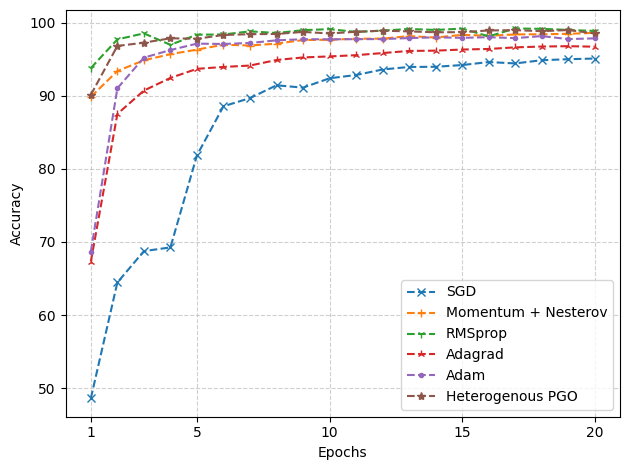

In [127]:
import matplotlib.pyplot as plt
epochs = range(1, len(accuracies_sgd) + 1)

plt.plot(epochs, accuracies_sgd, marker='x', linestyle='dashed', label='SGD')
plt.plot(epochs, accuracies_nag, marker='+', linestyle='dashed', label='Momentum + Nesterov')
plt.plot(epochs, accuracies_rmsprop, marker='1', linestyle='dashed', label='RMSprop')
plt.plot(epochs, accuracies_adagrad, marker='2', linestyle='dashed', label='Adagrad')
plt.plot(epochs, accuracies_adam, marker='.', linestyle='dashed', label='Adam')
plt.plot(epochs, accuracies_pgo, marker='*', linestyle='dashed', label='Heterogenous PGO')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=10)
tick_positions = [1, 5, 10, 15, 20]
plt.xticks(tick_positions)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.legend()
plt.show()

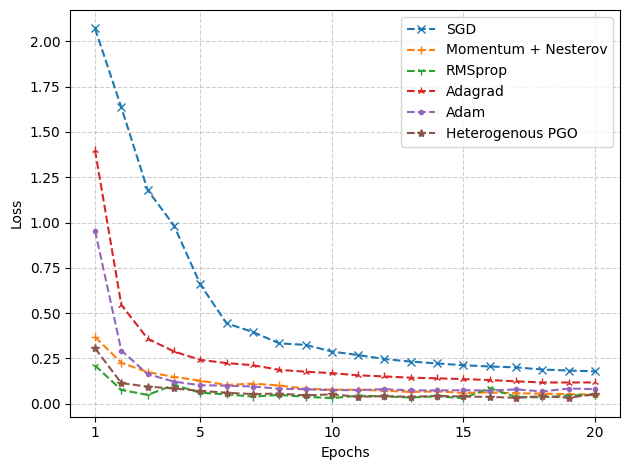

In [128]:
epochs = range(1, len(accuracies_sgd) + 1)

plt.plot(epochs, losses_sgd, marker='x', linestyle='dashed', label='SGD')
plt.plot(epochs, losses_nag, marker='+', linestyle='dashed', label='Momentum + Nesterov')
plt.plot(epochs, losses_rmsprop, marker='1', linestyle='dashed', label='RMSprop')
plt.plot(epochs, losses_adagrad, marker='2', linestyle='dashed', label='Adagrad')
plt.plot(epochs, losses_adam, marker='.', linestyle='dashed', label='Adam')
plt.plot(epochs, losses_pgo, marker='*', linestyle='dashed', label='Heterogenous PGO')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=10)
tick_positions = [1, 5, 10, 15, 20]
plt.xticks(tick_positions)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.legend()
plt.show()

In [93]:
losses = np.array([losses_sgd,
                  losses_nag,
                  losses_rmsprop,
                  losses_adagrad,
                  losses_adam,
                  losses_pgo])
np.save('losses_mnist.npy', losses)

In [94]:
accuracies = np.array([accuracies_sgd,
                  accuracies_nag,
                  accuracies_rmsprop,
                  accuracies_adagrad,
                  accuracies_adam,
                  accuracies_pgo])
np.save('accuracies_mnist.npy', accuracies)